# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow  = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
display(labels.head(15))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


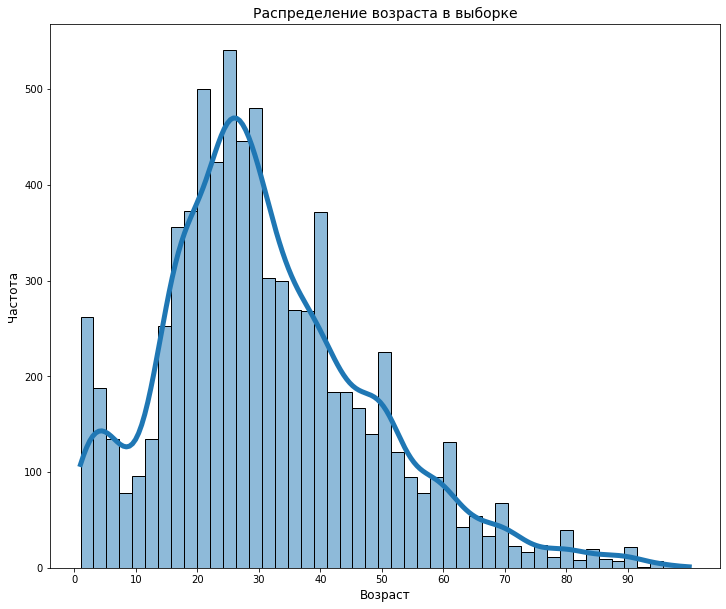

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [14]:
labels['real_age'].hist(bins=100, grid=False, figsize=(12,10), density=True)
plt.title('Распределение возраста в выборке', fontsize=14)
sns.histplot(labels['real_age'], kde=True, line_kws={'linewidth':5})
plt.xlabel('Возраст', fontsize=12)
plt.xticks(np.arange(0, 100, step=10)) 
plt.ylabel('Частота', fontsize=12)
plt.show()
labels['real_age'].describe()

Посмотрю на количество фотографий по возрасту.

In [32]:
grouped_labels= labels.groupby('real_age').size().reset_index(name='counts')
sorted_labels = grouped_labels.sort_values('counts', ascending=True)
sorted_labels.head(15)

,real_age,counts
96,100,1
95,97,1
90,91,1
91,93,1
94,96,2
93,95,2
80,81,3
82,83,3
85,86,3
87,88,3


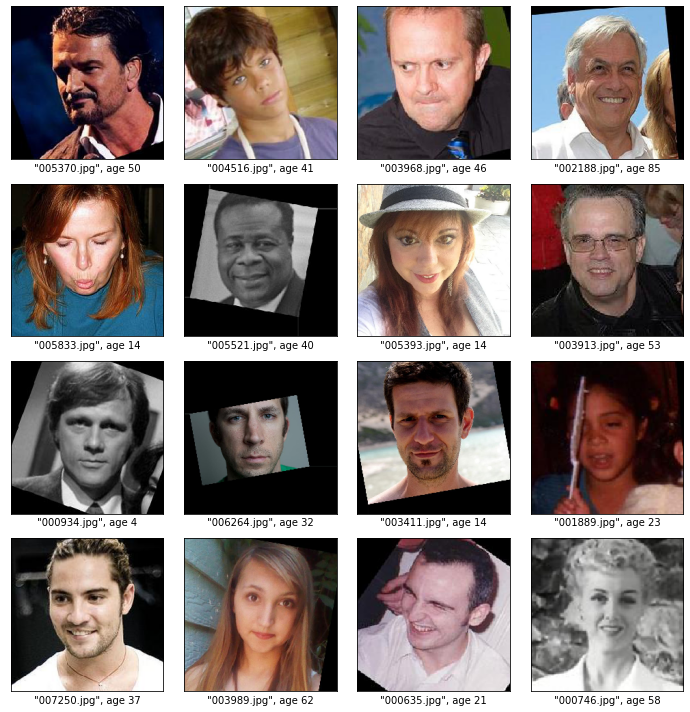

In [16]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(datagen_flow[1][0][i]) # i-тая картинка первого батча
    plt.xlabel(
        f'"{datagen_flow.filenames[datagen_flow.index_array[i]]}", age {datagen_flow[0][1][i]}'
    )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы по анализу:**

- Пропусков в данных нету.
- Всего имеем 7591 фотографий
- Минимальный возраст на фото 1 год, максимальный 100 лет.
- Преобладает фото с людьми возраст которых равен 20 от 35 лет.
- Меньше всего фотографий, возраст людей которых состовляет 90+. Всего несколько штук. Этого мало для обучения нейросети. Из этого следует, что нейросеть будет предсказывать возраст на фотографиях больше 90 лет хуже, чем тех, где количество фотографий больше. 
- В датасете присутствуют различные фотографии, не только цветные, но и чёрно-белые, так же некоторые фотографии имеют кроп и поворот. Предобработка не требуется.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

import pandas as pd
import numpy as np

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
          rescale=1./255,
          validation_split=0.2
          )

    train_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345) 

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2
      )

    test_gen_flow = test_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=path + 'final_files/',
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='validation',
          seed=12345) 

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(
    model,
    train_datagen_flow,
    test_data_flow,
    batch_size=None,
    epochs=5,
    steps_per_epoch=None,
    validation_steps=None
    ):
  
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_data_flow) 

    model.fit_generator(
      train_datagen_flow,
      validation_data=test_data_flow,
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      verbose=2,
      shuffle=True
  )

    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/5
190/190 - 65s - loss: 222.2569 - mae: 10.5851 - val_loss: 663.9552 - val_mae: 20.6704
Epoch 2/5
190/190 - 40s - loss: 62.2932 - mae: 5.9521 - val_loss: 736.8293 - val_mae: 21.7905
Epoch 3/5
190/190 - 40s - loss: 32.3527 - mae: 4.3741 - val_loss: 203.6495 - val_mae: 10.6273
Epoch 4/5
190/190 - 40s - loss: 20.7773 - mae: 3.5343 - val_loss: 90.5967 - val_mae: 7.3246
Epoch 5/5
190/190 - 40s - loss: 16.6127 - mae: 3.1610 - val_loss: 72.2827 - val_mae: 6.4272

```

## Анализ обученной модели

- Построена модель ResNet50 на предобученной выборке. Выборка была скачана с сервера Яндекса
- Точноесть предсказанной тестовой выборки была оценена с помощью метрики MAE и составила 6.42. Что удовлетворяет условию задачи, добиться значения MAE меньше 8.
- Данная модель способна предсказывать возраст человека по фотографии с точностью до 6.4 года.